In [1]:
import sys
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from sedfitter.sed import SEDCube
import pystellibs

In [2]:
sys.path.append('dev/')
from dev.spectral_interpolator import SpectrumGenerator
from dev.yso_model_loaders import S___SMI, SPUBHMI

In [3]:
base_path_yso = '/Users/ratzenboe/Documents/work/data_local/spectal_models/yso_models/models_richardson24/'
# yso_model = S___SMI(base_path_yso + 's---smi')
yso_model = SPUBHMI(base_path_yso + 'spubhmi')
spec_gen = SpectrumGenerator(stellib=pystellibs.BaSeL())

Loading SPUBHMI model...
SPUBHMI model loaded.


# Get YSO model data

In [30]:
logR, logT, logL, incl, logDiskMass, logDiskRmax, DiskBeta, DiskP, logDiskH100, logEnvRho0, CavityPow, CavityTheta0, logCavityRho0  = yso_model.X_input.values.T
# logg is 4.0 for all models in R17
logg = np.full_like(logR, 4.0)
Z = np.zeros_like(logR)
fnu = yso_model.y_output
wave_yso = yso_model.wave
aperture = yso_model.apertures
distances_pc = np.full(logR.shape[0], 1000) * u.pc
flam_yso = yso_model.transform_sed(fnu, distances_pc)

In [33]:
wave_yso.value

array([4.83863172e+07, 4.53135115e+07, 4.24358464e+07, 3.97409293e+07,
       3.72171547e+07, 3.48536542e+07, 3.26402494e+07, 3.05674083e+07,
       2.86262044e+07, 2.68082780e+07, 2.51058002e+07, 2.35114394e+07,
       2.20183296e+07, 2.06200407e+07, 1.93105511e+07, 1.80842215e+07,
       1.69357708e+07, 1.58602533e+07, 1.48530372e+07, 1.39097850e+07,
       1.30264347e+07, 1.21991822e+07, 1.14244649e+07, 1.06989465e+07,
       1.00195027e+07, 9.38320744e+06, 8.78732052e+06, 8.22927580e+06,
       7.70667009e+06, 7.21725280e+06, 6.75891629e+06, 6.32968675e+06,
       5.92771572e+06, 5.55127213e+06, 5.19873485e+06, 4.86858568e+06,
       4.55940286e+06, 4.26985491e+06, 3.99869489e+06, 3.74475507e+06,
       3.50694187e+06, 3.28423116e+06, 3.07566384e+06, 2.88034174e+06,
       2.69742369e+06, 2.52612198e+06, 2.36569890e+06, 2.21546359e+06,
       2.07476908e+06, 1.94300947e+06, 1.81961734e+06, 1.70406131e+06,
       1.59584375e+06, 1.49449862e+06, 1.39958947e+06, 1.31070760e+06,
      

# Fit spectra

In [6]:
points = np.array([logT, logg])
isin_param_range = spec_gen._spec_interpolator.points_inside(points.T)
print(f'Generating spectra for {isin_param_range.sum()} sources (out of {len(logT)})')
wave, specs = spec_gen._spec_interpolator.generate_individual_spectra(
    logT=logT[isin_param_range],
    logg=logg[isin_param_range],
    logL=logL[isin_param_range],
    Z=Z[isin_param_range],
)

Generating spectra for 680250 sources (out of 680250)


In [7]:
# Transform the spectra to astropy units
# First make sure the units are correct
wave = wave.to('Angstrom')
specs = specs.to('erg / (s * Angstrom)')
# now transform to astropy units
wave_ap = wave.magnitude * u.AA
specs_ap = specs.magnitude * u.erg / u.s / u.AA

# to avoid having to carry the mask around, we save NaNs for the spectra outside the range
specs_all = np.full((len(logT), len(wave)), np.nan) * u.erg / u.s / u.AA
specs_all[isin_param_range] = specs_ap

# Transform generic spectra to observed fluxes at Earth
distance_cm = distances_pc.to(u.cm)
flam = specs_all / (4 * np.pi * distance_cm[..., None] ** 2)

In [15]:
n_plt = 20
idx_all = np.random.choice(len(logT), size=n_plt, replace=False)

In [45]:
flam_yso[idx][10]

<Quantity [7.18353670e-26, 1.04292885e-25, 1.51418913e-25, 2.19843526e-25,
           3.19199659e-25, 4.63457657e-25, 6.72884976e-25, 9.76927708e-25,
           1.41838001e-24, 2.05924280e-24, 2.98920318e-24, 4.33812081e-24,
           6.29426376e-24, 9.13057792e-24, 1.32412187e-23, 1.91958888e-23,
           2.78183210e-23, 4.02939399e-23, 5.83312075e-23, 8.43875945e-23,
           1.21989677e-22, 1.76208772e-22, 2.54227863e-22, 3.66291436e-22,
           5.27062182e-22, 7.57244958e-22, 1.08581912e-21, 1.55358809e-21,
           2.21766900e-21, 3.15899402e-21, 4.49200148e-21, 6.37668086e-21,
           9.03779251e-21, 1.27787590e-20, 1.80251222e-20, 2.53521160e-20,
           3.55107160e-20, 4.95755620e-20, 6.88844817e-20, 9.52860706e-20,
           1.31028843e-19, 1.79259820e-19, 2.43434014e-19, 3.28380264e-19,
           4.39774539e-19, 5.83478309e-19, 7.59598924e-19, 9.73315281e-19,
           1.23235187e-18, 1.54222744e-18, 1.90690336e-18, 2.32962176e-18,
           2.81175979e-18

In [49]:
np.random.choice(len(aperture), size=1, replace=False)[0]

15

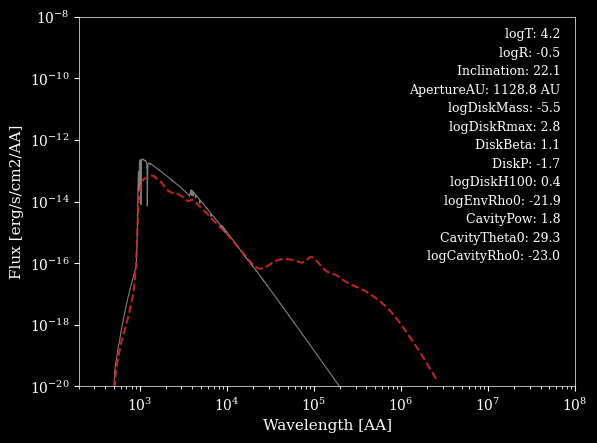

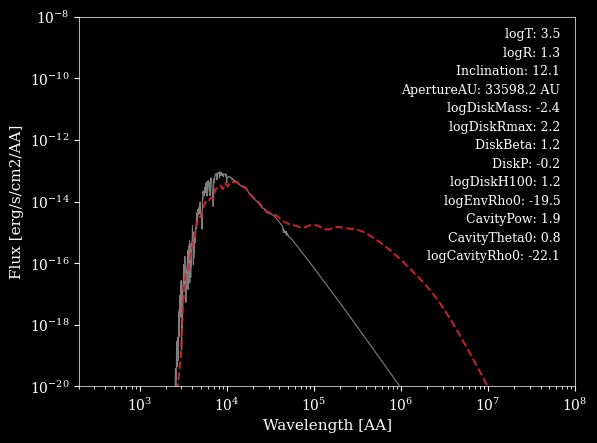

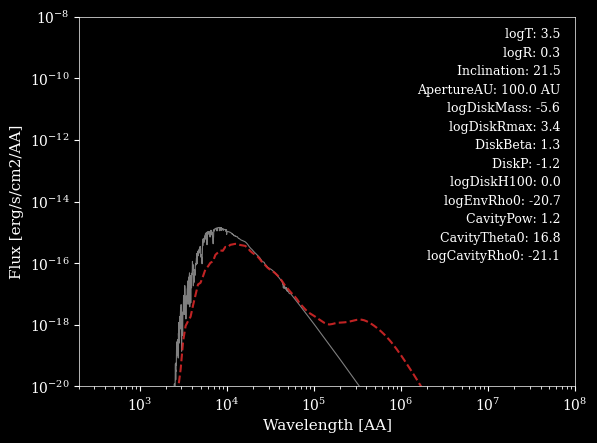

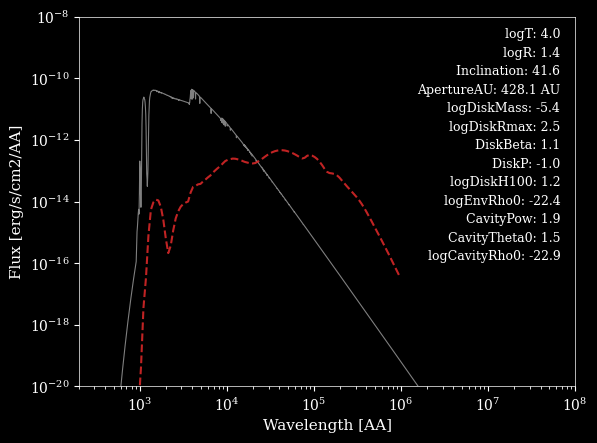

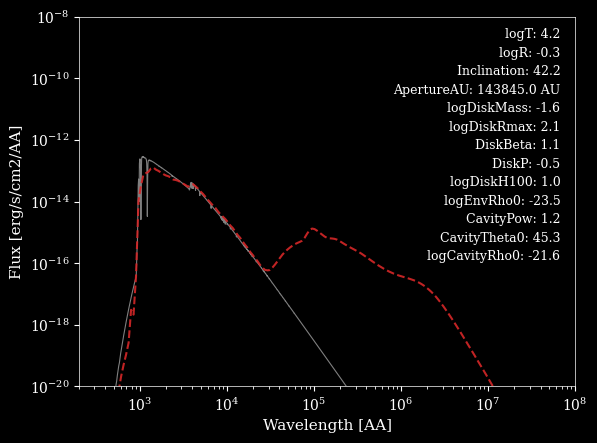

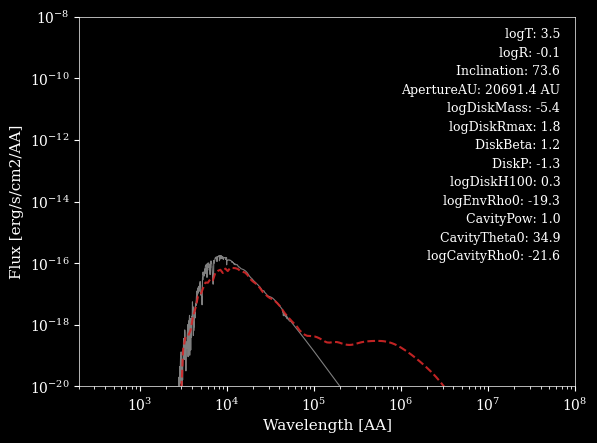

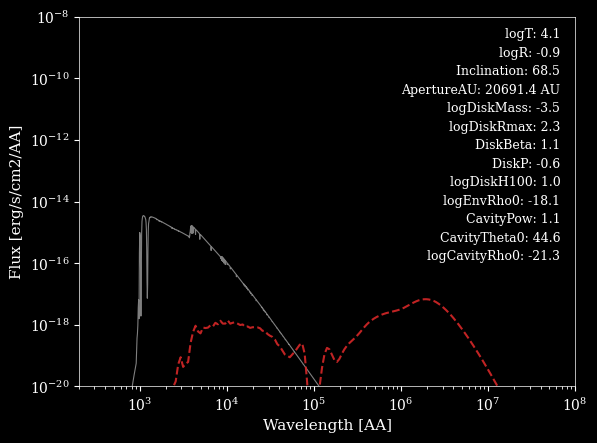

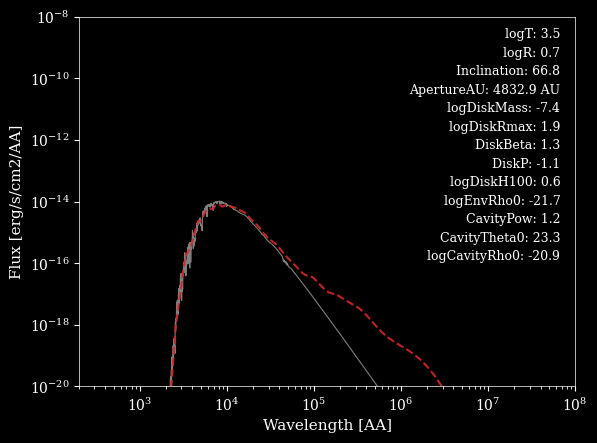

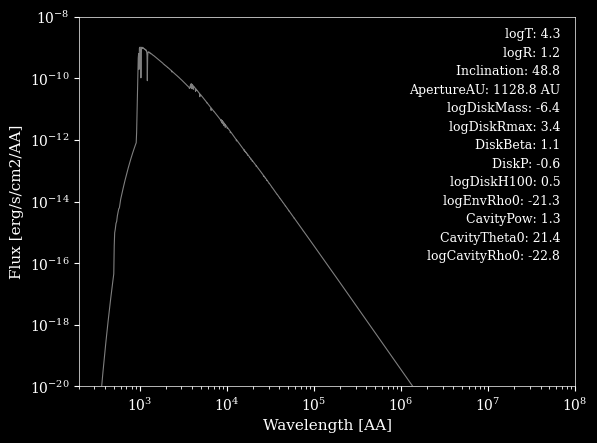

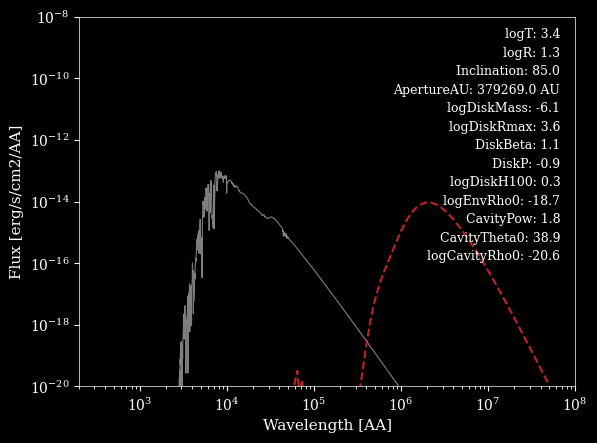

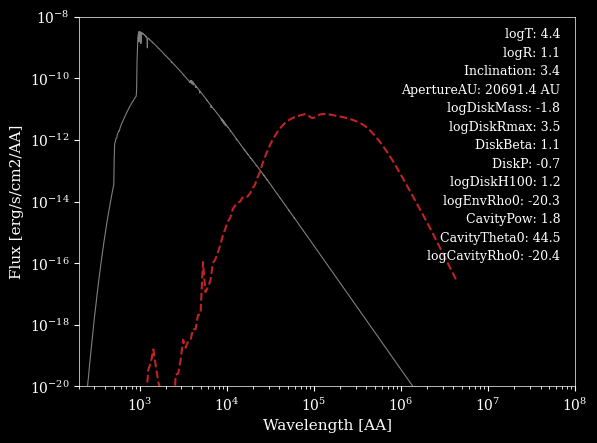

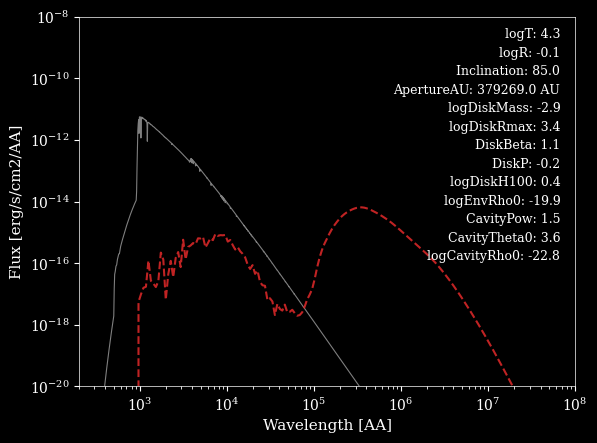

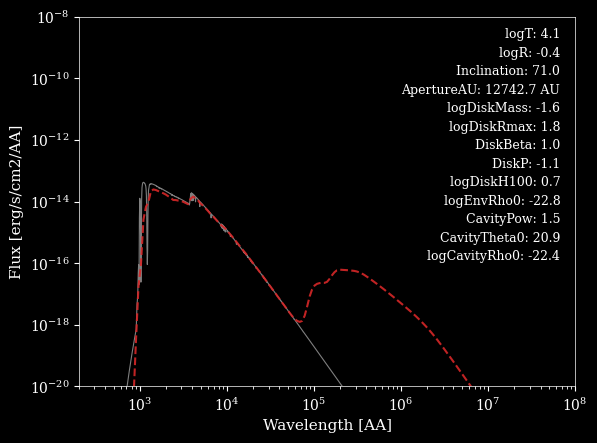

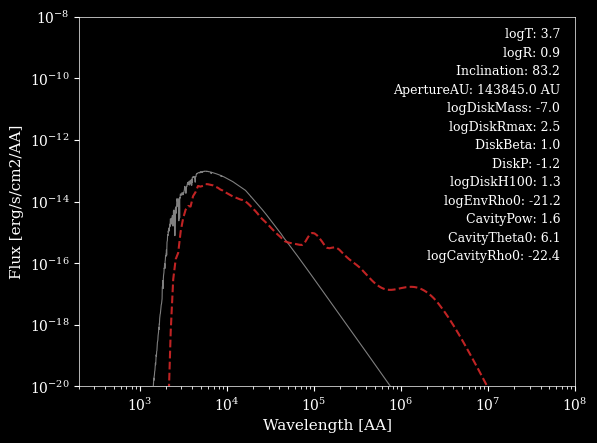

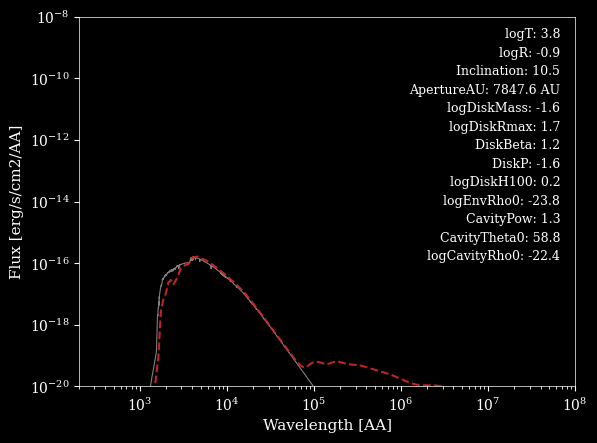

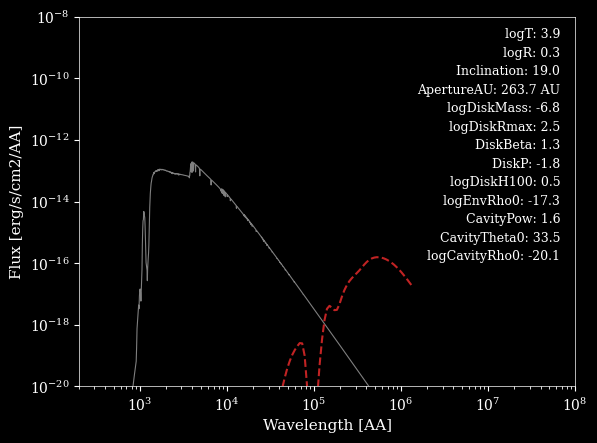

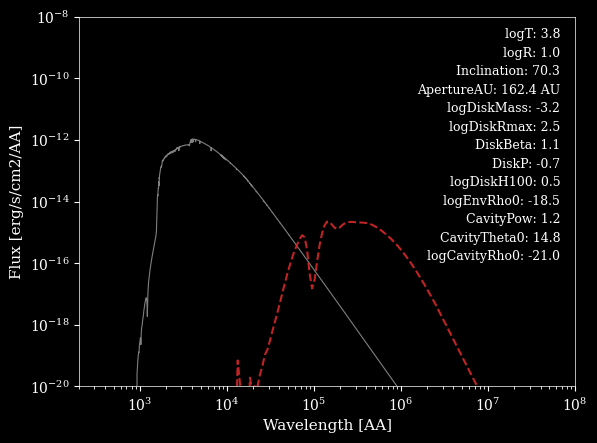

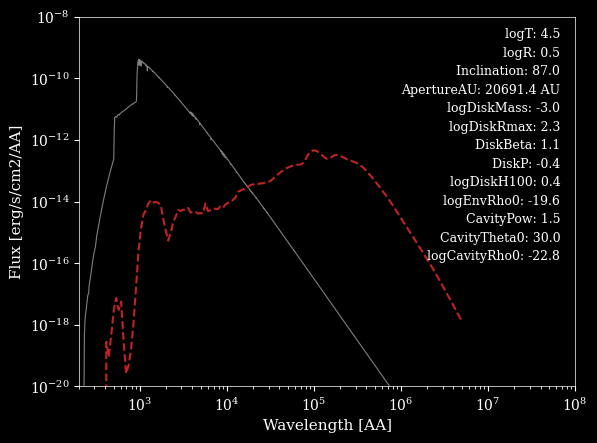

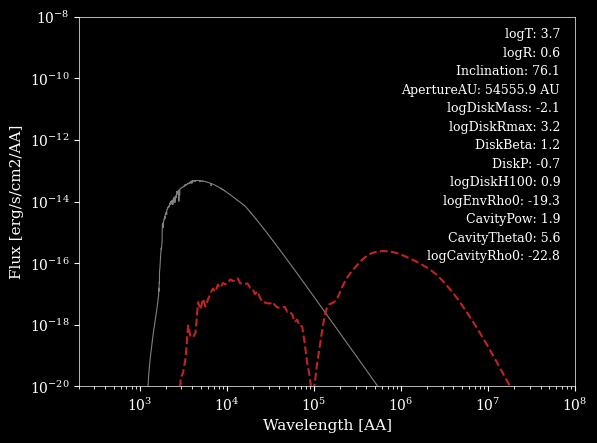

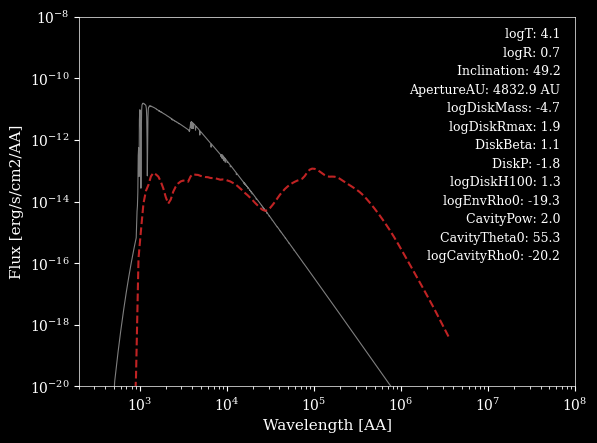

In [50]:
plt.style.use('dark_background')

for idx in idx_all:
    plt.loglog(wave_ap, flam[idx], 'tab:grey', lw=0.8, alpha=1)
    # Random aperture
    aperture_idx = np.random.choice(len(aperture), size=1, replace=False)[0]
    plt.loglog(wave_yso, flam_yso[idx][aperture_idx], 'tab:red', alpha=0.9, ls='--')
    components = dict(
        # DiskMass = data.logDiskMass[idx],
        logT = logT[idx],
        logR = logR[idx],
        Inclination = incl[idx],
        ApertureAU = aperture[aperture_idx],
        logDiskMass = logDiskMass[idx],
        logDiskRmax = logDiskRmax[idx],
        DiskBeta = DiskBeta[idx],
        DiskP = DiskP[idx],
        logDiskH100 = logDiskH100[idx],
        logEnvRho0 = logEnvRho0[idx],
        CavityPow = CavityPow[idx],
        CavityTheta0 = CavityTheta0[idx],
        logCavityRho0 = logCavityRho0[idx],
    )
    plt.xlabel('Wavelength [AA]', fontsize=11)
    plt.ylabel('Flux [erg/s/cm2/AA]', fontsize=11)
    plt.xlim(200, 1e8)
    plt.ylim(1e-20, 1e-8)
    # Set axis label sizes
    plt.tick_params(axis='both', which='major', labelsize=10)
    # Set label sizes
    for i, (desc, val) in enumerate(components.items()):
        # Put the text at the center of the plot
        plt.annotate(
            f"{desc}: {val:.1f}",
            xy=(0.97, 0.97 - i/20),  # Center of the plot
            xycoords="axes fraction",
            ha="right",
            va="top",
            fontsize=9,
            # bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
        )
    # Save figure
    plt.savefig(f'/Users/ratzenboe/Desktop/plts/yso_model_{idx}.png', dpi=300, bbox_inches='tight')
    plt.show()